In [60]:
from bs4 import BeautifulSoup
import requests
import numpy as np # library to handle data in a vectorized manner

import json # library to handle JSON files

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors


# import k-means from clustering stage
from sklearn.cluster import KMeans


print('Libraries imported.')

Libraries imported.


## Data Understanding and Preparation
### Let's take a look at our dataset. Here we read the data of SF business inspection CSV file 


In [2]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

In [3]:
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_5dcc2b08c7c64cd6a8aaf67cc18d690d = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='usGzz7kVzQN0rIe6Au_hwvw6bXlRPzNYZ65v4Z-WyNWy',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_5dcc2b08c7c64cd6a8aaf67cc18d690d.get_object(Bucket='capstoneproject-donotdelete-pr-jijn9nnnyidkg4',Key='DOHMH_New_York_City_Restaurant_Inspection_Results.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
NYC_df = pd.read_csv(body)
NYC_df.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,40698807,MAMA MIA 44 SW,Manhattan,621,9 AVENUE,10036.0,2123154582,Italian,07/19/2016,Violations were cited in the following area(s).,...,03/26/2020,Cycle Inspection / Initial Inspection,40.759633,-73.991763,104.0,3.0,12100.0,1026369.0,1.010530e+09,MN15
1,50079461,TEPPEN RAMEN,Manhattan,159,E 55TH ST,10022.0,2123552974,Japanese,07/23/2018,Violations were cited in the following area(s).,...,03/26/2020,Pre-permit (Operational) / Initial Inspection,40.759346,-73.969415,106.0,4.0,10000.0,1036532.0,1.013100e+09,MN19
2,41465581,MOLE,Manhattan,57,JANE STREET,10014.0,2122067577,Mexican,12/02/2019,Violations were cited in the following area(s).,...,03/26/2020,Cycle Inspection / Initial Inspection,40.738142,-74.005377,102.0,3.0,7700.0,1011646.0,1.006260e+09,MN23
3,50067916,ZIO TOTO,Brooklyn,8407,3RD AVE,11209.0,7182388042,Italian,09/13/2017,Establishment Closed by DOHMH. Violations wer...,...,03/26/2020,Pre-permit (Operational) / Initial Inspection,40.624869,-74.030469,310.0,43.0,6200.0,3152745.0,3.060250e+09,BK31
4,50045921,MOCHA MOCHA COFFEE,Brooklyn,8602,4TH AVE,11209.0,7184911300,Café/Coffee/Tea,01/07/2020,Violations were cited in the following area(s).,...,03/26/2020,Cycle Inspection / Initial Inspection,40.622677,-74.028407,310.0,43.0,6000.0,3153491.0,3.060440e+09,BK31


In [4]:
nyc_df = NYC_df.drop(columns=['BUILDING','PHONE','INSPECTION TYPE','ACTION','VIOLATION CODE','CRITICAL FLAG','RECORD DATE','GRADE DATE','Community Board','Council District','Census Tract','BIN','BBL','NTA'])

In [6]:
nyc_df.head()

,CAMIS,DBA,BORO,STREET,ZIPCODE,CUISINE DESCRIPTION,INSPECTION DATE,VIOLATION DESCRIPTION,SCORE,GRADE,Latitude,Longitude
0,40698807,MAMA MIA 44 SW,Manhattan,9 AVENUE,10036.0,Italian,07/19/2016,Facility not vermin proof. Harborage or condit...,18.0,NaN,40.759633,-73.991763
1,50079461,TEPPEN RAMEN,Manhattan,E 55TH ST,10022.0,Japanese,07/23/2018,Facility not vermin proof. Harborage or condit...,21.0,NaN,40.759346,-73.969415
2,41465581,MOLE,Manhattan,JANE STREET,10014.0,Mexican,12/02/2019,"Food contact surface not properly washed, rins...",24.0,NaN,40.738142,-74.005377
3,50067916,ZIO TOTO,Brooklyn,3RD AVE,11209.0,Italian,09/13/2017,Cold food item held above 41º F (smoked fish a...,76.0,NaN,40.624869,-74.030469
4,50045921,MOCHA MOCHA COFFEE,Brooklyn,4TH AVE,11209.0,Café/Coffee/Tea,01/07/2020,Food not cooked to required minimum temperature.,19.0,NaN,40.622677,-74.028407


In [5]:
nyc_df.shape

(402042, 12)

So each row consists of 11 features:
> 1. **CAMIS**: Unique number used for identification of the business 
> 2. **DBA**: Business Name
> 3. **STREET**: The address of the business 
> 4. **ZIPCODE**: Zip code of establishment (restaurant) location
> 5. **CUISINE DESCRIPTION**: This field describes the entity (restaurant) cuisine
> 6. **INSPECTION DATE**: The date of the inspection process
> 7. **VIOLATION DESCRIPTION**: Short description of the violation if any
> 8. **SCORE**: Total score for a particular inspection
> 9. **GRADE**: Classification of the business category, A, B or C
> 10. **Latitude**: The latitude value of the business location
> 11. **Longitude**: The longitude value of the business location 


In [7]:
copy_nyc_df = nyc_df

In [8]:
copy_nyc_df.dropna(subset=['CAMIS','DBA','BORO'
                          ,'STREET', 'SCORE',
                          'ZIPCODE','Latitude','Longitude',
                          'CUISINE DESCRIPTION',
                          'INSPECTION DATE','GRADE',
                          'VIOLATION DESCRIPTION'],inplace=True)

In [9]:
copy_nyc_df = copy_nyc_df[~copy_nyc_df['GRADE'].isin(['G','N','P','Z'])]

In [10]:
def getMonth(s):
    return s.split("/")[0]

def getDay(s):
    return s.split("/")[1]

def getYear(s):
     ss= s.split("/")[2]
     return ss[:4]

def getYearMonth(s):
    return s.split("/")[1]+"/"+s.split("/")[2]

In [11]:
copy_nyc_df['year']= copy_nyc_df['INSPECTION DATE'].apply(lambda x: getYear(str(x)))
copy_nyc_df['Month']= copy_nyc_df['INSPECTION DATE'].apply(lambda x: getMonth(str(x)))
copy_nyc_df['day']= copy_nyc_df['INSPECTION DATE'].apply(lambda x: getDay(str(x)))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [12]:
copy_nyc_df =copy_nyc_df[~copy_nyc_df.year.str.contains("2020")]

In [13]:
copy_nyc_df.shape

(177653, 15)

### We groupd the inspections by year for each category A, B and C

In [14]:
df_risk = copy_nyc_df.groupby('GRADE', axis=0).count()
df_risk.head(6)

,CAMIS,DBA,BORO,STREET,ZIPCODE,CUISINE DESCRIPTION,INSPECTION DATE,VIOLATION DESCRIPTION,SCORE,Latitude,Longitude,year,Month,day
GRADE,,,,,,,,,,,,,,
A,144670,144670,144670,144670,144670,144670,144670,144670,144670,144670,144670,144670,144670,144670
B,24021,24021,24021,24021,24021,24021,24021,24021,24021,24021,24021,24021,24021,24021
C,8962,8962,8962,8962,8962,8962,8962,8962,8962,8962,8962,8962,8962,8962


In [15]:
df_risk_score = copy_nyc_df.groupby('GRADE', axis=0)['SCORE'].mean()
df_risk_score.head()

GRADE
A    10.062300
B    20.842846
C    36.777840
Name: SCORE, dtype: float64

In [16]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.0.2


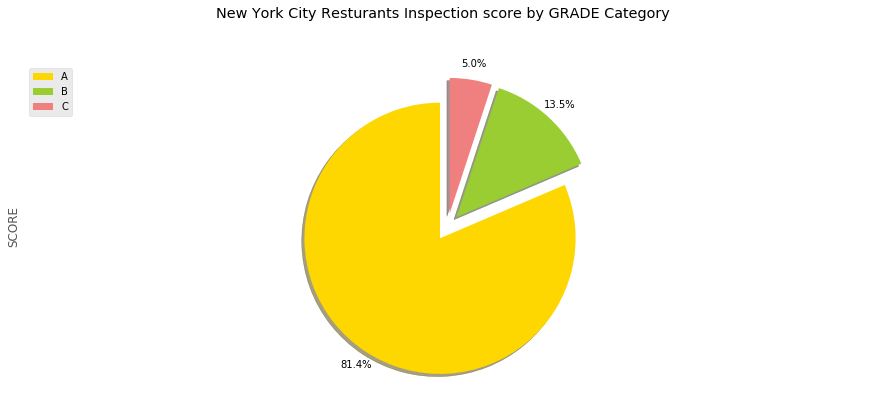

In [17]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
explode_list = [0.1, 0.1, 0.1] # ratio for each continent with which to offset each wedge.

df_risk['SCORE'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents
                            )

# scale the title up by 12% to match pctdistance
plt.title('New York City Resturants Inspection score by GRADE Category', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=df_risk.index, loc='upper left') 

plt.show()

In [18]:
nyc_df_year = copy_nyc_df.groupby(['GRADE','year'])['INSPECTION DATE'].count()
nyc_df_year

GRADE  year
A      2014        2
       2015       35
       2016     7366
       2017    32089
       2018    48385
       2019    56793
B      2015        5
       2016     1072
       2017     4652
       2018     8318
       2019     9974
C      2014        5
       2016      304
       2017     1364
       2018     3209
       2019     4080
Name: INSPECTION DATE, dtype: int64

In [19]:
years = list(map(str, range(2014, 2019)))
nyc_df_year.index

MultiIndex(levels=[['A', 'B', 'C'], ['2014', '2015', '2016', '2017', '2018', '2019']],
           codes=[[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2], [0, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 0, 2, 3, 4, 5]],
           names=['GRADE', 'year'])

In [20]:
df_gptest = copy_nyc_df[['GRADE','year','INSPECTION DATE']]
df_risk_year = df_gptest.groupby(['GRADE','year'],as_index= False).count()

In [21]:
all(isinstance(column, str) for column in df_risk_year.columns)

True

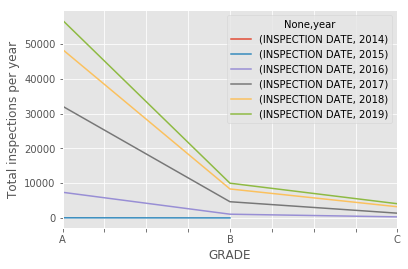

In [22]:
grouped_pivot = df_risk_year.pivot(index='GRADE',columns='year').plot()
#grouped_pivot
plt.ylabel('Total inspections per year');

In [23]:
import seaborn as sns
import re

#### Using busnisses with address, let's duplicate each business's address based on how much they have been inspected to the total inspections.

In [24]:
copy_nyc_df.Month = copy_nyc_df.Month.astype(np.int64)
copy_nyc_df.day = copy_nyc_df.day.astype(np.int64)

## Calculate Percentage of New York City business incepections btween 2014-2019

In [25]:
un_nyc_df = nyc_df_year.unstack()

In [26]:
df_all_year = un_nyc_df.T
df_all_year

GRADE,A,B,C
year,,,
2014,2.0,NaN,5.0
2015,35.0,5.0,NaN
2016,7366.0,1072.0,304.0
2017,32089.0,4652.0,1364.0
2018,48385.0,8318.0,3209.0
2019,56793.0,9974.0,4080.0


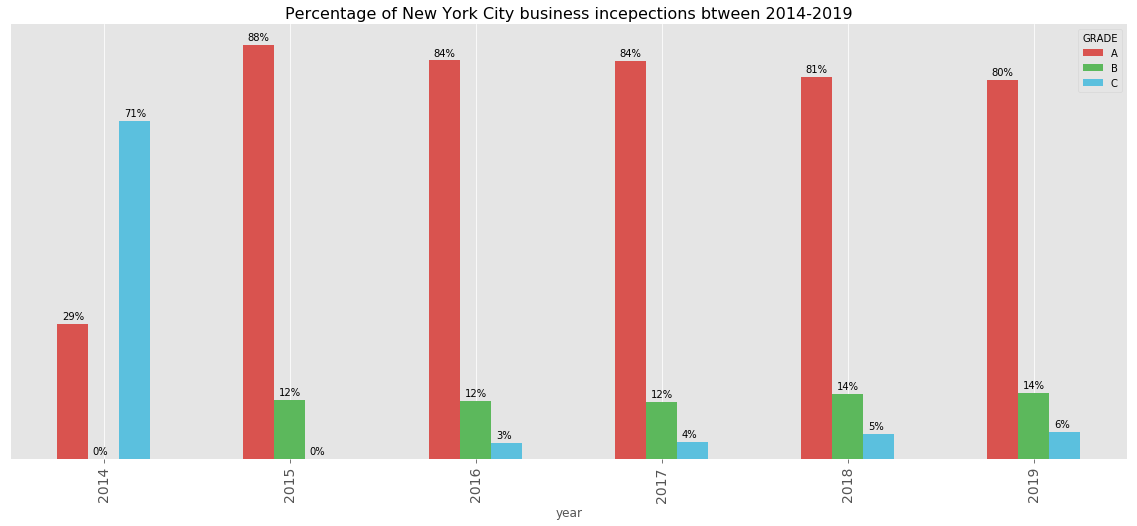

In [27]:
ax = df_all_year.div(df_all_year.sum(1), axis=0).plot(kind='bar', color=['#d9534f','#5cb85c', '#5bc0de' ], figsize=(20, 8))

ax.set_title("Percentage of New York City business incepections btween 2014-2019",fontsize=16)
plt.xticks(fontsize=14)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(height), (p.get_x()+.15*width, p.get_y() + height + 0.01))

In [28]:
nyc_count= copy_nyc_df['ZIPCODE'].value_counts().to_frame()
nyc_count .rename(columns={'ZIPCODE': 'Count'}, inplace=True)
nyc_count.index.name ='ZIPCODE'
nyc_count.reset_index(level=0, inplace=True)

In [29]:
!pip install wordcloud

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

     |████████████████████████████████| 368kB 7.7MB/s eta 0:00:01
Wordcloud is installed and imported!


In [30]:
stopwords = set(STOPWORDS)

In [31]:
lst_v_dsc = copy_nyc_df['VIOLATION DESCRIPTION'].tolist()

word_string = " ".join(str(s) for s in lst_v_dsc)

wordcloud = WordCloud(background_color='white', max_words=2000,stopwords=stopwords).generate(word_string)

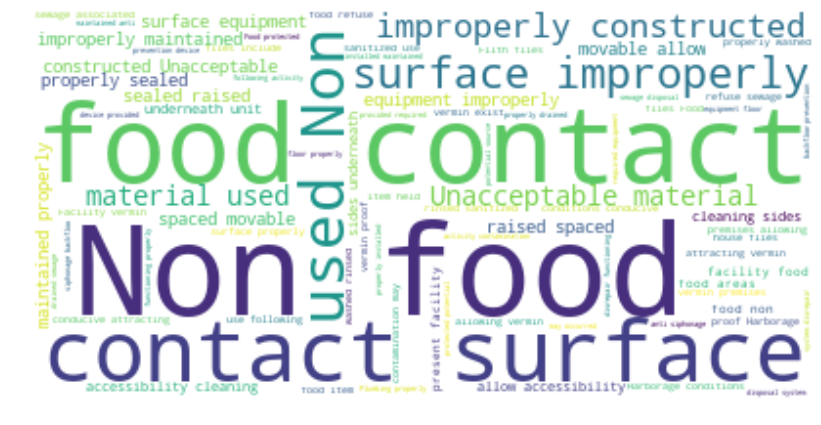

In [33]:
stopwords.add('Moderate risk') # add the words said to stopwords
stopwords.add('risk')
stopwords.add('Moderate')
# re-generate the word cloud
wordcloud.generate(word_string)

fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

# display the cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [34]:
copy_nyc_df.shape

(177653, 15)

# visualize the data on new york city

In [35]:
!conda install -c conda-forge folium=0.10.1 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.10.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    folium-0.10.1              |             py_0          59 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be

In [47]:
import folium # goelogical map
nyc_map = folium.Map(location=[40.767937,-73.982155 ],tiles='OpenStreetMap',zoom_start=12)

for each in copy_nyc_df[:1000].iterrows():
    folium.CircleMarker([each[1]['Latitude'],each[1]['Longitude']],
                        radius=2,
                        color="red"
                        ).add_to(nyc_map)

nyc_map

#### Let's find out how many entries there are in our new dataframe.

In [44]:
copy_nyc_df.shape

(177653, 15)

So the dataframe consists of 177653 inspections, which took place in period 2014-2019. In order to reduce computational cost, let's just work with the first 100 inspections in this dataset.

In [45]:
# get the first 100 crimes in the df_incidents dataframe
limit = 100
copy_nyc_df_limt = copy_nyc_df.iloc[0:limit, :]
copy_nyc_df_limt.shape

(100, 15)

Now that we reduced the data a little bit, let's visualize where these inspections took place in the city of new york. We will use the default style and we will initialize the zoom level to 12. 

Now let's superimpose the locations of the crimes onto the map. The way to do that in **Folium** is to create a *feature group* with its own features and style and then add it to the sanfran_map.

We can also add some pop-up text that would get displayed when we hover over a marker. Let's make each marker display the category of the inspection when hovered over.

In [52]:
# instantiate a feature group for the incidents in the dataframe
inspection = folium.Map(location=[40.767937,-73.982155 ],tiles='OpenStreetMap',zoom_start=12)

# loop through the 100 crimes and add each to the incidents feature group
for each in copy_nyc_df_limt[:100].iterrows():
    folium.CircleMarker([each[1]['Latitude'],each[1]['Longitude']],
                        radius=2,
                        color="red"
                        ).add_to(inspection)
   
    
#  map
inspection

In [59]:
from folium import plugins

# let's start again with a clean copy of the map of San Francisco
sanfran_map = folium.Map(location=[40.767937,-73.982155 ], zoom_start = 12)

# instantiate a mark cluster object for the incidents in the dataframe
inspection = plugins.MarkerCluster().add_to(sanfran_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(copy_nyc_df_limt.Latitude, copy_nyc_df_limt.Longitude, copy_nyc_df_limt.GRADE):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(inspection)

# display map
sanfran_map

## Modeling
In this part of our project we will apply a machine learning technique to cluster and classifying the inspection in order to have a better understanding of inspection process. 
### Features extraction
Before start the modeling stage We need to:
> convert inspection_date field to date time object

> drop unnecessary fields from the dataset 

In [63]:
copy_nyc_df['INSPECTION DATE'] = pd.to_datetime(copy_nyc_df['INSPECTION DATE'])


In [65]:
m_nyc_df = copy_nyc_df
m_nyc_df.head(5)

,CAMIS,DBA,BORO,STREET,ZIPCODE,CUISINE DESCRIPTION,INSPECTION DATE,VIOLATION DESCRIPTION,SCORE,GRADE,Latitude,Longitude,year,Month,day
5,50038549,ANGKOR CAMBODIAN BISTRO,Manhattan,E 64TH ST,10065.0,Asian,2016-12-12,Plumbing not properly installed or maintained;...,9.0,A,40.762382,-73.958880,2016,12,12
6,41529391,CHINA WOK,Brooklyn,AVENUE T,11234.0,Chinese,2019-04-26,"Food contact surface not properly washed, rins...",5.0,A,40.615279,-73.918465,2019,4,26
10,50054646,CHINA ONE RESTAURANT,Bronx,E GUN HILL RD,10467.0,Chinese,2019-06-06,Non-food contact surface improperly constructe...,8.0,A,40.878809,-73.873198,2019,6,6
12,50078609,CHOI FOOK RESTAURANT,Brooklyn,86TH ST,11214.0,Seafood,2018-12-27,Cold food item held above 41º F (smoked fish a...,25.0,B,40.603889,-73.997090,2018,12,27
13,40838446,STARBUCKS,Manhattan,2 AVENUE,10021.0,Café/Coffee/Tea,2016-09-21,Wiping cloths soiled or not stored in sanitizi...,5.0,A,40.771043,-73.956738,2016,9,21


Let’s see how many of each class is in our data set 

In [68]:
m_nyc_df['GRADE'].value_counts()


A    144670
B     24021
C      8962
Name: GRADE, dtype: int64

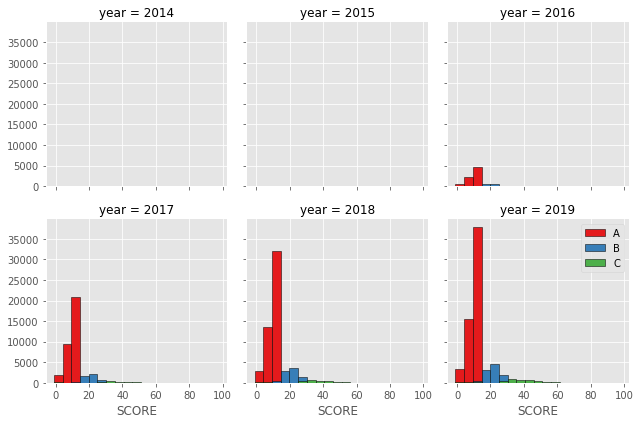

In [69]:
#### bins = np.linspace(m_nyc_df.SCORE.min(), m_nyc_df.SCORE.max(), 20)
g = sns.FacetGrid(m_nyc_df, col="year", hue="GRADE", palette="Set1", col_wrap=3)
g.map(plt.hist, 'SCORE', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

#### Lets look at the day of the week businesses were getting inspected 

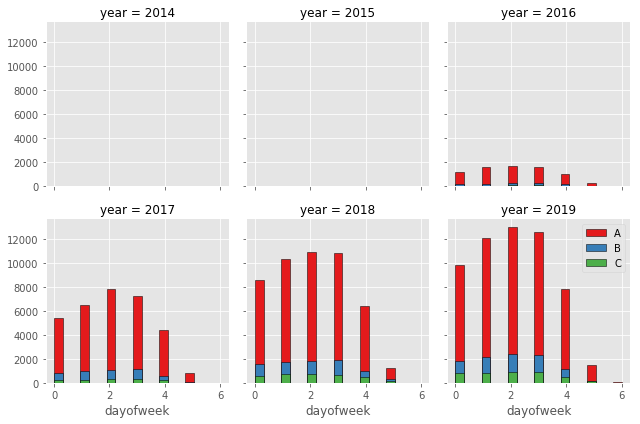

In [70]:
m_nyc_df['dayofweek'] = m_nyc_df['INSPECTION DATE'].dt.dayofweek
bins = np.linspace(m_nyc_df.dayofweek.min(), m_nyc_df.dayofweek.max(), 20)
g = sns.FacetGrid(m_nyc_df, col="year", hue="GRADE", palette="Set1", col_wrap=3)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that businesses that get inspected at the end of the week so lets use Feature binarization to set a threshold values less then day 4 

In [71]:
m_nyc_df['weekend'] = m_nyc_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
m_nyc_df.head()

,CAMIS,DBA,BORO,STREET,ZIPCODE,CUISINE DESCRIPTION,INSPECTION DATE,VIOLATION DESCRIPTION,SCORE,GRADE,Latitude,Longitude,year,Month,day,dayofweek,weekend
5,50038549,ANGKOR CAMBODIAN BISTRO,Manhattan,E 64TH ST,10065.0,Asian,2016-12-12,Plumbing not properly installed or maintained;...,9.0,A,40.762382,-73.958880,2016,12,12,0,0
6,41529391,CHINA WOK,Brooklyn,AVENUE T,11234.0,Chinese,2019-04-26,"Food contact surface not properly washed, rins...",5.0,A,40.615279,-73.918465,2019,4,26,4,1
10,50054646,CHINA ONE RESTAURANT,Bronx,E GUN HILL RD,10467.0,Chinese,2019-06-06,Non-food contact surface improperly constructe...,8.0,A,40.878809,-73.873198,2019,6,6,3,0
12,50078609,CHOI FOOK RESTAURANT,Brooklyn,86TH ST,11214.0,Seafood,2018-12-27,Cold food item held above 41º F (smoked fish a...,25.0,B,40.603889,-73.997090,2018,12,27,3,0
13,40838446,STARBUCKS,Manhattan,2 AVENUE,10021.0,Café/Coffee/Tea,2016-09-21,Wiping cloths soiled or not stored in sanitizi...,5.0,A,40.771043,-73.956738,2016,9,21,2,0


### Convert Categorical features to numerical values

In [72]:
m_nyc_df =m_nyc_df[~m_nyc_df.year.str.contains("2020")]

In [73]:
m_nyc_df = m_nyc_df[~m_nyc_df['GRADE'].isin(['G','N','P','Z'])]

In [74]:
m_nyc_df.groupby(['year'])['GRADE'].value_counts(normalize=True)


year  GRADE
2014  C        0.714286
      A        0.285714
2015  A        0.875000
      B        0.125000
2016  A        0.842599
      B        0.122626
      C        0.034775
2017  A        0.842120
      B        0.122084
      C        0.035796
2018  A        0.807601
      B        0.138837
      C        0.053562
2019  A        0.801629
      B        0.140782
      C        0.057589
Name: GRADE, dtype: float64

from the result above we can see that in mostly all years the C Grade is increasing.

Lets convert the risk categories into 1 for A, 2 for B and 3 for C:

In [75]:
m_nyc_df['GRADE'].replace(to_replace=['A','B','C'], value=[1,2,3],inplace=True)
m_nyc_df.head()

,CAMIS,DBA,BORO,STREET,ZIPCODE,CUISINE DESCRIPTION,INSPECTION DATE,VIOLATION DESCRIPTION,SCORE,GRADE,Latitude,Longitude,year,Month,day,dayofweek,weekend
5,50038549,ANGKOR CAMBODIAN BISTRO,Manhattan,E 64TH ST,10065.0,Asian,2016-12-12,Plumbing not properly installed or maintained;...,9.0,1,40.762382,-73.958880,2016,12,12,0,0
6,41529391,CHINA WOK,Brooklyn,AVENUE T,11234.0,Chinese,2019-04-26,"Food contact surface not properly washed, rins...",5.0,1,40.615279,-73.918465,2019,4,26,4,1
10,50054646,CHINA ONE RESTAURANT,Bronx,E GUN HILL RD,10467.0,Chinese,2019-06-06,Non-food contact surface improperly constructe...,8.0,1,40.878809,-73.873198,2019,6,6,3,0
12,50078609,CHOI FOOK RESTAURANT,Brooklyn,86TH ST,11214.0,Seafood,2018-12-27,Cold food item held above 41º F (smoked fish a...,25.0,2,40.603889,-73.997090,2018,12,27,3,0
13,40838446,STARBUCKS,Manhattan,2 AVENUE,10021.0,Café/Coffee/Tea,2016-09-21,Wiping cloths soiled or not stored in sanitizi...,5.0,1,40.771043,-73.956738,2016,9,21,2,0


From the dataset we can define our feature set, X as follows:

In [76]:
Feature = m_nyc_df[['ZIPCODE','Latitude',
             'Longitude','SCORE',
              'year', 'dayofweek']]
my_features = Feature
X = my_features
X[0:5]

,ZIPCODE,Latitude,Longitude,SCORE,year,dayofweek
5,10065.0,40.762382,-73.958880,9.0,2016,0
6,11234.0,40.615279,-73.918465,5.0,2019,4
10,10467.0,40.878809,-73.873198,8.0,2019,3
12,11214.0,40.603889,-73.997090,25.0,2018,3
13,10021.0,40.771043,-73.956738,5.0,2016,2


To build a machine learning classifier we need a label set Y as follows:

In [77]:
y = m_nyc_df['GRADE']
y[0:5]

5     1
6     1
10    1
12    2
13    1
Name: GRADE, dtype: int64

### Classification 
Now, it is time to use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Logistic Regression

#### K Nearest Neighbor(KNN)
We should find the best k to build the model with the best accuracy.  

In [78]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (142122, 6) (142122,)
Test set: (35531, 6) (35531,)


In [79]:
Ks = 10

mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc






print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

The best accuracy was with 0.9954687456024317 with k= 1


In [91]:
neigh = KNeighborsClassifier(n_neighbors = 6).fit(X_train,y_train)
yhatKNN = neigh.predict(X_test)
print("*******************kNN********************")
print("Train set Accuracy--> ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy -->", metrics.accuracy_score(y_test, yhatKNN))
print("F1  Accuracy -->", metrics.f1_score(y_test, yhatKNN, average='weighted'))

*******************kNN********************
Train set Accuracy-->  0.9905785170487328
Test set Accuracy --> 0.9891925360952408
F1  Accuracy --> 0.9890100705888452


#### Logistic Regression

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

In [93]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhatLR = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [94]:
print("Train set Accuracy--> ", metrics.accuracy_score(y_train, LR.predict(X_train)))
print("Test set Accuracy -->", metrics.accuracy_score(y_test, yhatLR))

Train set Accuracy-->  0.958043089739801
Test set Accuracy --> 0.95814922180631


In [95]:
log_loss(y_test, yhat_prob)

0.21539236966174133

In [96]:
jaccard_similarity_score(y_test, yhatKNN)

0.9891925360952408

In [97]:
jaccard_similarity_score(y_test, yhatLR)

0.95814922180631

In [87]:
#f1LR = f1_score(y, yhatLR, average='weighted')
print("Regression F1  Accuracy -->", metrics.f1_score(y_test, yhatLR, average='weighted'))

Regression F1  Accuracy --> 0.9559698645101655


In [100]:
print("*******************kNN********************")
print("Train set Accuracy--> ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy -->", metrics.accuracy_score(y_test, yhatKNN))
print("F1  Accuracy -->", metrics.f1_score(y_test, yhatKNN, average='weighted'))
print("Jaccard Score -->",jaccard_similarity_score(y_test, yhatKNN))

print("*******************Logistic Regression********************")
print("Train set Accuracy--> ", metrics.accuracy_score(y_train, LR.predict(X_train)))
print("Test set Accuracy -->", metrics.accuracy_score(y_test, yhatLR))
print("Regression F1  Accuracy -->", metrics.f1_score(y_test, yhatLR, average='weighted'))
print("Jaccard Score -->",jaccard_similarity_score(y_test, yhatLR))
print("LogLoss -->", log_loss(y_test, yhat_prob))


*******************kNN********************
Train set Accuracy-->  0.9905785170487328
Test set Accuracy --> 0.9891925360952408
F1  Accuracy --> 0.9890100705888452
Jaccard Score --> 0.9891925360952408
*******************Logistic Regression********************
Train set Accuracy-->  0.958043089739801
Test set Accuracy --> 0.95814922180631
Regression F1  Accuracy --> 0.9559698645101655
Jaccard Score --> 0.95814922180631
LogLoss --> 0.21539236966174133


## Using Fourquare to visualize businesses venues
We will make calls to the Foursquare API for different purposes. You will construct a URL to send a request to the API to search for a specific type of venues, to explore a particular business venue, to explore a Foursquare user, to explore a geographical location, and to get trending venues around a location. Also, you will learn how to use the visualization library, Folium, to visualize the results.

### Import necessary Libraries
first we import some libraries that we need to complete our object effeciently 

In [101]:
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import requests # library to handle requests
import random # library for random number generation

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


### Define Foursquare Credentials
we define Foursquare Credentials and Version. We have already created a Foursquare developer account and have we credentials handy.

In [102]:
CLIENT_ID = 'EGJ4JLYHQDQDV05Y3AJB1CDSUBGWT1XURNJAWKVGFZYIZZRR' # your Foursquare ID
CLIENT_SECRET = '2BKSLK4VVRZGHP2HQ5TXQICQP13YK0E5ES3A3SZ3UGYPBAWY' # your Foursquare Secret
VERSION = '20181022'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EGJ4JLYHQDQDV05Y3AJB1CDSUBGWT1XURNJAWKVGFZYIZZRR
CLIENT_SECRET:2BKSLK4VVRZGHP2HQ5TXQICQP13YK0E5ES3A3SZ3UGYPBAWY


In order to reduce computational cost, let's just work with the first 100 inspections in this dataset.

In [103]:
# get the first 100 inspections in the our dataframe
df_limit = 100
Top100_nyc_df = nyc_df.iloc[0:df_limit, :]
Top100_nyc_df.shape

(100, 12)

In [193]:
Top100_nyc_df.head(20)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,year,Month,day
5,50038549,ANGKOR CAMBODIAN BISTRO,Manhattan,408,E TH ST,10065.0,2127582111,Asian,2016-12-12,Violations were cited in the following area(s).,...,-73.958880,108.0,5.0,10602.0,1045384.0,1.014580e+09,MN31,2016,12,12
6,41529391,CHINA WOK,Brooklyn,5813,AVENUE T,11234.0,7182095999,Chinese,2019-04-26,Violations were cited in the following area(s).,...,-73.918465,318.0,46.0,68800.0,3236237.0,3.083800e+09,BK58,2019,4,26
10,50054646,CHINA ONE RESTAURANT,Bronx,334,E GUN HILL RD,10467.0,7187980109,Chinese,2019-06-06,Violations were cited in the following area(s).,...,-73.873198,207.0,11.0,42902.0,2018503.0,2.033520e+09,BX43,2019,6,6
12,50078609,CHOI FOOK RESTAURANT,Brooklyn,2050,TH ST,11214.0,7189752818,Seafood,2018-12-27,Violations were cited in the following area(s).,...,-73.997090,311.0,47.0,28800.0,3166942.0,3.063760e+09,BK28,2018,12,27
13,40838446,STARBUCKS,Manhattan,1449,AVENUE,10021.0,2124720653,Café/Coffee/Tea,2016-09-21,Violations were cited in the following area(s).,...,-73.956738,108.0,4.0,13400.0,1044060.0,1.014308e+09,MN31,2016,9,21
14,41185899,POCHA 32,Manhattan,15,WEST STREET,10001.0,2122791876,Korean,2018-07-10,Violations were cited in the following area(s).,...,-73.986170,105.0,4.0,7600.0,1083631.0,1.008340e+09,MN17,2018,7,10
18,50005783,GOLDEN KRUST CARIBBEAN BAKERY & GRILL,Queens,22324,S CONDUIT AVE,11413.0,7183411600,Caribbean,2019-12-09,Violations were cited in the following area(s).,...,-73.754412,413.0,31.0,68000.0,4287377.0,4.135030e+09,QN03,2019,12,9
19,50043707,DRAGON GARDEN,Queens,8618,ROCKAWAY BEACH BLVD,11693.0,7189451808,Chinese,2018-10-11,Violations were cited in the following area(s).,...,-73.811507,414.0,32.0,94202.0,4303412.0,4.161200e+09,QN12,2018,10,11
22,40386001,PRIMOLA RESTAURANT,Manhattan,1226,SECOND AVENUE,10065.0,2127581775,Italian,2019-09-16,Violations were cited in the following area(s).,...,-73.961904,108.0,5.0,11800.0,1044690.0,1.014390e+09,MN31,2019,9,16
24,50072097,BARCELO RESTAURANT,Queens,5533,MYRTLE AVE,11385.0,9179091511,"Latin (Cuban, Dominican, Puerto Rican, South &...",2018-03-28,Violations were cited in the following area(s).,...,-73.907505,405.0,34.0,55100.0,4082441.0,4.034510e+09,QN20,2018,3,28


### Define the API URL
Here we will define the corresponding URL and send the GET Request and examine the results
we have chosen one business for the sake of simplicity. This business name is "OMNI S.F. Hotel" it is Low Risk business inspection an it got 96 score. 

In [118]:
latitude = 40.743163694
longitude = -73.987662716
search_query = 'The Evelyn'
radius = 100
print(search_query + ' .... OK!')

The Evelyn .... OK!


In [119]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=EGJ4JLYHQDQDV05Y3AJB1CDSUBGWT1XURNJAWKVGFZYIZZRR&client_secret=2BKSLK4VVRZGHP2HQ5TXQICQP13YK0E5ES3A3SZ3UGYPBAWY&ll=40.743163694,-73.987662716&v=20181022&query=The Evelyn&radius=100&limit=30'

In [120]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e8729b81e152c001bb228d9'},
 'response': {'venues': [{'id': '54d28e3d498e0c5aead5e697',
    'name': 'The Evelyn',
    'location': {'address': '7 E 27th St',
     'lat': 40.74399251335605,
     'lng': -73.98726565432484,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.74399251335605,
       'lng': -73.98726565432484}],
     'distance': 98,
     'postalCode': '10016',
     'cc': 'US',
     'neighborhood': 'NoMad',
     'city': 'New York',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['7 E 27th St',
      'New York, NY 10016',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d1fa931735',
      'name': 'Hotel',
      'pluralName': 'Hotels',
      'shortName': 'Hotel',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
       'suffix': '.png'},
      'primary': True}],
    'venuePage': {'id': '498308614'},
    'referralId': 'v-1585916411',
    'hasPerk': False},

#### Get relevant part of JSON and transform it into a *pandas* dataframe

In [121]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head(10)

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",False,54d28e3d498e0c5aead5e697,7 E 27th St,US,New York,United States,NaN,98,"[7 E 27th St, New York, NY 10016, United States]","[{'label': 'display', 'lat': 40.74399251335605...",40.743993,-73.987266,NoMad,10016,NY,The Evelyn,v-1585916411,498308614
1,"[{'id': '4bf58dd8d48988d124941735', 'name': 'O...",False,4af845b2f964a520c00b22e3,71 5th Ave Fl 8 #F,US,New York,United States,15th St,30,"[71 5th Ave Fl 8 #F (15th St), New York, NY 10...","[{'label': 'display', 'lat': 40.74295719858241...",40.742957,-73.987901,NaN,10003,NY,The Gate Worldwide,v-1585916411,NaN
2,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",False,40b68100f964a5207d001fe3,Madison Ave,US,New York,United States,btwn E 23rd & E 26th St,104,"[Madison Ave (btwn E 23rd & E 26th St), New Yo...","[{'label': 'display', 'lat': 40.74226204193276...",40.742262,-73.988006,NaN,10010,NY,Madison Square Park,v-1585916411,NaN
3,"[{'id': '4bf58dd8d48988d130941735', 'name': 'B...",False,54cfa489498e6e5d8ad6cfff,205 E 42nd St,US,New York,United States,NaN,72,"[205 E 42nd St, New York, NY 10017, United Sta...","[{'label': 'display', 'lat': 40.74262228156258...",40.742622,-73.988137,NaN,10017,NY,The Mobile Majority,v-1585916411,NaN
4,[],False,4c9cc12bd3c2b60c2882babc,226 5th Ave,US,New York,United States,27th Street,40,"[226 5th Ave (27th Street), New York, NY 10001...","[{'label': 'display', 'lat': 40.74353018333333...",40.743530,-73.987709,NaN,10001,NY,Bid on the City,v-1585916411,NaN
5,"[{'id': '4bf58dd8d48988d174941735', 'name': 'C...",False,4f749002e4b0250b716ac544,NaN,US,New York,United States,NaN,46,"[New York, NY 10010, United States]","[{'label': 'display', 'lat': 40.7435140177621,...",40.743514,-73.987953,NaN,10010,NY,Office Of The Head S.P.I.,v-1585916411,NaN
6,"[{'id': '4bf58dd8d48988d176941735', 'name': 'G...",False,51c88f61498e7394b032b27a,NaN,US,New York,United States,NaN,50,"[New York, NY, United States]","[{'label': 'display', 'lat': 40.74358784128637...",40.743588,-73.987861,NaN,NaN,NY,The Official Derek Jeter Gym,v-1585916411,NaN
7,"[{'id': '4bf58dd8d48988d174941735', 'name': 'C...",False,54621f8d498ec51131112dc7,234 5th Ave,US,New York,United States,27th Street,117,"[234 5th Ave (27th Street), New York, NY 10001...","[{'label': 'display', 'lat': 40.74420782431841...",40.744208,-73.987862,NaN,10001,NY,The Yard: Flatiron South,v-1585916411,NaN
8,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",False,5d7e8ed06bceab0008144eed,NaN,US,New York,United States,NaN,67,"[New York, NY 10010, United States]","[{'label': 'display', 'lat': 40.743038, 'lng':...",40.743038,-73.986881,NaN,10010,NY,The Counter by Joe Coffee Company,v-1585916411,NaN
9,"[{'id': '4bf58dd8d48988d174941735', 'name': 'C...",False,4d6675816d86224be1049381,220 5th Ave,US,New York,United States,NaN,49,"[220 5th Ave, New York, NY 10001, United States]","[{'label': 'display', 'lat': 40.74355268488688...",40.743553,-73.987954,NaN,10001,NY,The Sandbox @ GlobalWorks,v-1585916411,NaN


In [122]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,The Evelyn,Hotel,7 E 27th St,US,New York,United States,NaN,98,"[7 E 27th St, New York, NY 10016, United States]","[{'label': 'display', 'lat': 40.74399251335605...",40.743993,-73.987266,NoMad,10016,NY,54d28e3d498e0c5aead5e697
1,The Gate Worldwide,Office,71 5th Ave Fl 8 #F,US,New York,United States,15th St,30,"[71 5th Ave Fl 8 #F (15th St), New York, NY 10...","[{'label': 'display', 'lat': 40.74295719858241...",40.742957,-73.987901,NaN,10003,NY,4af845b2f964a520c00b22e3
2,Madison Square Park,Park,Madison Ave,US,New York,United States,btwn E 23rd & E 26th St,104,"[Madison Ave (btwn E 23rd & E 26th St), New Yo...","[{'label': 'display', 'lat': 40.74226204193276...",40.742262,-73.988006,NaN,10010,NY,40b68100f964a5207d001fe3
3,The Mobile Majority,Building,205 E 42nd St,US,New York,United States,NaN,72,"[205 E 42nd St, New York, NY 10017, United Sta...","[{'label': 'display', 'lat': 40.74262228156258...",40.742622,-73.988137,NaN,10017,NY,54cfa489498e6e5d8ad6cfff
4,Bid on the City,None,226 5th Ave,US,New York,United States,27th Street,40,"[226 5th Ave (27th Street), New York, NY 10001...","[{'label': 'display', 'lat': 40.74353018333333...",40.743530,-73.987709,NaN,10001,NY,4c9cc12bd3c2b60c2882babc
5,Office Of The Head S.P.I.,Coworking Space,NaN,US,New York,United States,NaN,46,"[New York, NY 10010, United States]","[{'label': 'display', 'lat': 40.7435140177621,...",40.743514,-73.987953,NaN,10010,NY,4f749002e4b0250b716ac544
6,The Official Derek Jeter Gym,Gym,NaN,US,New York,United States,NaN,50,"[New York, NY, United States]","[{'label': 'display', 'lat': 40.74358784128637...",40.743588,-73.987861,NaN,NaN,NY,51c88f61498e7394b032b27a
7,The Yard: Flatiron South,Coworking Space,234 5th Ave,US,New York,United States,27th Street,117,"[234 5th Ave (27th Street), New York, NY 10001...","[{'label': 'display', 'lat': 40.74420782431841...",40.744208,-73.987862,NaN,10001,NY,54621f8d498ec51131112dc7
8,The Counter by Joe Coffee Company,Coffee Shop,NaN,US,New York,United States,NaN,67,"[New York, NY 10010, United States]","[{'label': 'display', 'lat': 40.743038, 'lng':...",40.743038,-73.986881,NaN,10010,NY,5d7e8ed06bceab0008144eed
9,The Sandbox @ GlobalWorks,Coworking Space,220 5th Ave,US,New York,United States,NaN,49,"[220 5th Ave, New York, NY 10001, United States]","[{'label': 'display', 'lat': 40.74355268488688...",40.743553,-73.987954,NaN,10001,NY,4d6675816d86224be1049381


#### Let's visualize the restaurants that are nearby

In [123]:
dataframe_filtered.name

0                                         The Evelyn
1                                 The Gate Worldwide
2                                Madison Square Park
3                                The Mobile Majority
4                                    Bid on the City
5                          Office Of The Head S.P.I.
6                       The Official Derek Jeter Gym
7                           The Yard: Flatiron South
8                  The Counter by Joe Coffee Company
9                          The Sandbox @ GlobalWorks
10                         The Lunchbox @GlobalWorks
11                                   The Gilded Lady
12                                        The Fallen
13                                 The Grand Madison
14                             The Salt Lick Bar-B-Q
15                                  The New Republic
16                                      Urban Angler
17                                            'Essen
18                                            

In [127]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Hotel

for each in dataframe_filtered[:100].iterrows():
    folium.CircleMarker([each[1]['lat'],each[1]['lng']],
                        radius=2,
                        color="red"
                        ).add_to(venues_map)

# display map
venues_map

Let us check this business rating since it has a Low Risk category.

In [128]:
venue_id = '54d28e3d498e0c5aead5e697' # ID of The Evelyn
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

6.9


 We can see it has a better rating, let's explore it further. let us see how many tips it has.

In [129]:
result['response']['venue']['tips']['count']

13

Let us get the tips and list of associated features

In [130]:
## Evelyn Tips
limit = 15 # set limit to be greater than or equal to the total number of tips
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e872cab14a126001b76f222'},
 'response': {'tips': {'count': 13,
   'items': [{'id': '5b52d9c9f62e09002cc6d91e',
     'createdAt': 1532156361,
     'text': 'Rooms are tighter than usual for NYC and a bit awkward in layout, bed comfy, can be a bit noisy. Location very convenient for Madison Square Park / Flat Iron.',
     'type': 'user',
     'canonicalUrl': 'https://foursquare.com/item/5b52d9c9f62e09002cc6d91e',
     'photo': {'id': '5b52d9cf898bdc002c977f88',
      'createdAt': 1532156367,
      'source': {'name': '4sq for iOS (internal)',
       'url': 'http://developer.foursquare.com'},
      'prefix': 'https://fastly.4sqi.net/img/general/',
      'suffix': '/4856851_2ugkr9-72C1AMPOJwA6aLLr8Om1lCoz4VI2SjX-Y8rM.jpg',
      'width': 1440,
      'height': 1920,
      'visibility': 'public'},
     'photourl': 'https://fastly.4sqi.net/img/general/original/4856851_2ugkr9-72C1AMPOJwA6aLLr8Om1lCoz4VI2SjX-Y8rM.jpg',
     'lang': 'en',
     'likes': {'count

In [131]:
tips = results['response']['tips']['items']

tip = results['response']['tips']['items'][0]
tip.keys()

dict_keys(['id', 'createdAt', 'text', 'type', 'canonicalUrl', 'photo', 'photourl', 'lang', 'likes', 'logView', 'agreeCount', 'disagreeCount', 'lastVoteText', 'lastUpvoteTimestamp', 'todo', 'user'])

In [132]:
pd.set_option('display.max_colwidth', -1)

tips_df = json_normalize(tips) # json normalize tips

# columns to keep
filtered_columns = ['text', 'agreeCount', 'disagreeCount', 'id', 'user.firstName', 'user.lastName', 'user.gender', 'user.id']
tips_filtered = tips_df.loc[:, filtered_columns]

# display tips
tips_filtered

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,text,agreeCount,disagreeCount,id,user.firstName,user.lastName,user.gender,user.id
0,"Rooms are tighter than usual for NYC and a bit awkward in layout, bed comfy, can be a bit noisy. Location very convenient for Madison Square Park / Flat Iron.",3,0,5b52d9c9f62e09002cc6d91e,Marissa,C,NaN,4856851


Because we are using a personal developer account, then we can access only 2 of the hotel's tips, instead of all 15 tips.

We can explore further by asking some question such as:
 > Who is this Marissa that rate this hotel?
 
 > How many tips has this user submitted?
 
 > Does she have complete profile (e.g. image, bio and etc.)?

In [143]:
user_id = '4856851' # user ID with most agree counts and complete profile

url = 'https://api.foursquare.com/v2/users/{}?client_id={}&client_secret={}&v={}'.format(user_id, CLIENT_ID, CLIENT_SECRET, VERSION) # define URL

# send GET request
results = requests.get(url).json()
user_data = results

# display features associated with user
user_data.keys()
user_data

{'meta': {'code': 401,
  'errorType': 'invalid_auth',
  'errorDetail': 'Missing oauth_token. See https://developer.foursquare.com/docs/api/configuration/authentication for details.',
  'requestId': '5e872e23006dce001b8b73bf'},
 'response': {}}

Marissa is less active in Foursquare as we can see she has 14 tips. Let us explore them.

In [144]:
# define tips URL
url = 'https://api.foursquare.com/v2/users/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(user_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)

# send GET request and get user's tips
results = requests.get(url).json()
tips = results['response']['tips']['items']

# format column width
pd.set_option('display.max_colwidth', -1)

tips_df = json_normalize(tips)

# filter columns
filtered_columns = ['text', 'agreeCount', 'disagreeCount', 'id']
tips_filtered = tips_df.loc[:, filtered_columns]

# display user's tips
tips_filtered

,text,agreeCount,disagreeCount,id
0,"Just got their liquor license and in soft opening, live music at night",1,0,5d44fed994b4af0007d8eaf2
1,"The main beach ... go to the far end where it’s most quiet. Be on the lookout for a lady selling pie or a popsicle guy, you won’t regret either! 🥧🏝",0,0,5c717ac1ff0306002c657818
2,"Great place to watch the boats, birds and grab a snack. Friendly service. Located on the water.",0,0,5c717a5aaa6c95002c95719e
3,Quinn & Jenny are great instructors. You can dive even if not certified at a WW2 ship wreck! Try the Discover Scuba with an extra dive to visit the 🚢,0,0,5c336cb09b0473002b3a4e78
4,"Good little Thai spot with views of the ocean. Grab a spot on the balcony, and some mussels in coconut broth.",1,0,5c277eca95d986002cd8d07f
5,"One of my favorite New Mexican spots in Santa Fe, great margaritas and blue corn enchiladas",0,0,5c1f0d7764c8e1002c640380
6,"Best place in Santa Fe for firewood. $40 for a wheelbarrow full of piñon, $50 for oak/cedar.",0,0,5c1d3a86f00a70002cbc90b8
7,Great for brunch ... don’t miss the blueberry scones,0,0,5be9e680898bdc002c2921bb
8,Delicious cocktails and cool vibe ... feels like a less kitschy tiki bar with wider array of drinks.,5,0,5be9e64c4ac28a002cb38943
9,"Amazing food and cocktails, relaxed ambiance. Menu let’s you try lots of dishes and share with a group. Don’t miss the Pity the Fool 🍹",0,0,5be9e5f12d2fd9002c1451b0


let us explore one venue with highest agree count

In [140]:
tip_id = '5be9e64c4ac28a002cb38943' # tip id

# define URL
url = 'http://api.foursquare.com/v2/tips/{}?client_id={}&client_secret={}&v={}'.format(tip_id, CLIENT_ID, CLIENT_SECRET, VERSION)

# send GET Request and examine results
result = requests.get(url).json()
print(result['response']['tip']['venue']['name'])
print(result['response']['tip']['venue']['location'])

Bon Voyage
{'address': '584 Valencia St', 'crossStreet': '17th St', 'lat': 37.763585561392055, 'lng': -122.4219544792981, 'labeledLatLngs': [{'label': 'display', 'lat': 37.763585561392055, 'lng': -122.4219544792981}], 'postalCode': '94110', 'cc': 'US', 'neighborhood': 'Mission Dolores', 'city': 'San Francisco', 'state': 'CA', 'country': 'United States', 'formattedAddress': ['584 Valencia St (17th St)', 'San Francisco, CA 94110', 'United States']}


From the data above Nadia was in a resturant called "Bon Voyage" in San Francisco